<a style="font-size: 3em;">Bachelor Thesis: Modeling and Simulating Limit Order Books</a>

Adan Fhima

# Imports and tool functions


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
import pandas as pd


np.random.seed(42)

# Part 1 - Modeling the Market Order Flow

## Objectives

- **Define and simulate** (near‐critical) **Hawkes processes** for buy and sell order arrivals.
- **Compute** the resulting price path under a propagator model.
- **Measure** the impact function of the metaorder
- **Show** that the market impact is asymptotically a **power law**

## Define Model Parameters and Kernels

Before simulating order flow, we need to define the key parameters and kernel functions that shape the model.

First, we set the constant:
- **$ \mu $** (baseline order intensity)

Next, we define the **Hawkes process kernel** $ \phi(t) $, which models how past orders influence future ones. We assume an **exponential decay** function:

$$
\phi(t) = a e^{-b t}
$$

For the process to remain stable, the kernel must satisfy the stability condition:

$$
\int_0^{+\infty} \phi(s) ds = \frac{a}{b} < 1.
$$


To model how orders impact price, we define the **propagator function** $ \zeta(t) $. The key relationship:

$$
\zeta'(t) = -\zeta(0) \phi(t)
$$

ensures that price impact decays over time in response to past trades. Here:
- $ \zeta(0) $ represents the **immediate impact of an order**.
- The decay ensures that impact is **transient**, meaning price does not drift indefinitely due to a single trade.

With these parameters in place, we are now ready to **simulate order flow **.


Stability condition (a/b): 0.95


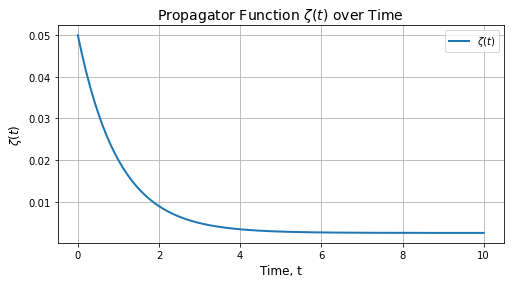

In [2]:
# Set parameters for the nearly unstable Hawkes process kernel.
mu = 0.5           # Baseline intensity 
a = 0.95          
b = 1.0            

# stability condition 
stability_condition = a / b
print(f"Stability condition (a/b): {stability_condition:.2f}")

def phi(t):
    return a * np.exp(-b * t)

# Initial value ζ(0)
zeta0 = 0.05

def zeta(t):
    return zeta0 * (1 - (a / b) * (1 - np.exp(-b * t)))


t_test = np.linspace(0, 10, 200)
zeta_values = zeta(t_test)
plt.figure(figsize=(8, 4))
plt.plot(t_test, zeta_values, label=r"$\zeta(t)$", lw=2)
plt.xlabel("Time, t", fontsize=12)
plt.ylabel(r"$\zeta(t)$", fontsize=12)
plt.title("Propagator Function $\zeta(t)$ over Time", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


The plot shows how order flow impacts price over time.

- At $ t = 0 $, $ \zeta(0) $ represents the immediate price jump** caused by an order.
- As $ t $ increases, $ \zeta(t) $ decays, meaning past orders lose influence on price.
If $ \zeta(t) $ decays slowly, order flow has a long-lasting impact, leading to **persistent price moves**.
If $ \zeta(t) $ decays quickly, price impact is short-lived, meaning **the market absorbs orders faster**.




## Simulating Order Flow Using the Hawkes Process

In this step, we generate **numerical buy and sell order flows** using a **Hawkes process**.

**How It Works ?**
Each market order (buy or sell) **increases the probability** of future orders arriving soon after it.
The Hawkes intensity function $ \lambda_t $ controls how often orders appear:
  
  $$
  \lambda_t = \mu + \int_0^t \phi(t - s) dN_s
  $$

- We simulate two independent streams:
  - **Buy orders** $ N^a_t $.
  - **Sell orders** $ N^b_t $.



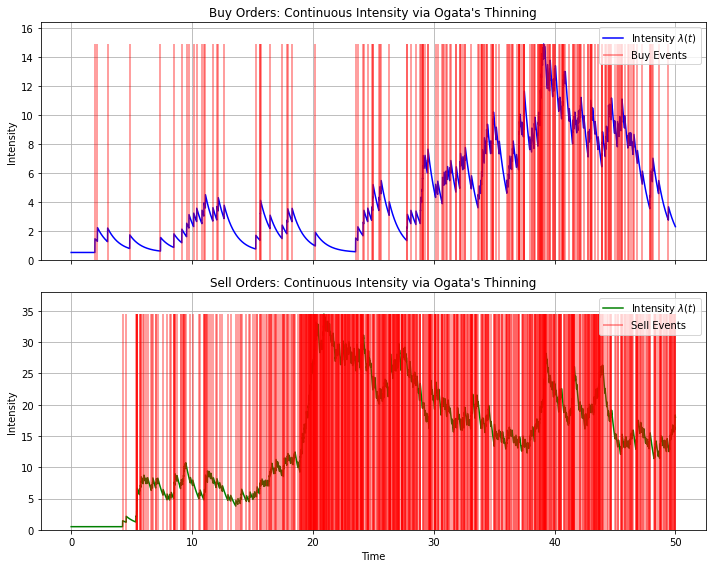

In [3]:
#Use Ogata's Thinning Algorithm to Generate a Continuous Plot
# ref : https://www.math.fsu.edu/~ychen/research/Thinning%20algorithm.pdf

def simulate_hawkes_process(mu, T, phi, initial_t=0):
    events = []  
    t = initial_t
    while t < T:
        if events:
            current_intensity = mu + np.sum(phi(t - np.array(events)))
        else:
            current_intensity = mu
        lambda_bar = current_intensity  # current intensity upper bound

        u = np.random.rand()
        w = -np.log(u) / lambda_bar
        t_candidate = t + w
        if t_candidate > T:
            break  
        
        if events:
            intensity_candidate = mu + np.sum(phi(t_candidate - np.array(events)))
        else:
            intensity_candidate = mu
        
        if np.random.rand() <= intensity_candidate / lambda_bar:
            events.append(t_candidate)
        
        t = t_candidate  #
    
    return np.array(events)

# Simulation parameters
T = 50.0       
dt = 0.01      

buy_events = simulate_hawkes_process(mu, T, phi)
sell_events = simulate_hawkes_process(mu, T, phi)

time_grid = np.linspace(0, T, int(T/dt))

def compute_intensity(t, events, mu, phi):
    past_events = events[events < t]
    return mu + np.sum(phi(t - past_events))


lambda_buy_cont = np.array([compute_intensity(t, buy_events, mu, phi) for t in time_grid])
lambda_sell_cont = np.array([compute_intensity(t, sell_events, mu, phi) for t in time_grid])


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# Plot for Buy Orders
axes[0].plot(time_grid, lambda_buy_cont, label=r'Intensity $\lambda(t)$', color='blue')
axes[0].vlines(buy_events, ymin=0, ymax=np.max(lambda_buy_cont), color='red', alpha=0.5, label='Buy Events')
axes[0].set_ylabel("Intensity")
axes[0].set_title("Buy Orders: Continuous Intensity via Ogata's Thinning")
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(0, np.max(lambda_buy_cont) * 1.1)  # Adjusting Y-scale for better visibility

# Plot for Sell Orders
axes[1].plot(time_grid, lambda_sell_cont, label=r'Intensity $\lambda(t)$', color='green')
axes[1].vlines(sell_events, ymin=0, ymax=np.max(lambda_sell_cont), color='red', alpha=0.5, label='Sell Events')
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Intensity")
axes[1].set_title("Sell Orders: Continuous Intensity via Ogata's Thinning")
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(0, np.max(lambda_sell_cont) * 1.1)  # Adjusting Y-scale independently

plt.tight_layout()
plt.savefig("hawkes_process_intensity.png", dpi=300)
plt.show()


The plot shows **event times for buy (blue) and sell (green) orders**.

Clusters of ticks indicate periods of **heightened activity**, which is a typical feature of self-exciting Hawkes processes.
The spacing between the events gives an idea of how the intensity of the process changes over time.

## Interpretation of the Propagator Model for Price Impact

The plot represents the **evolution of the price process $ P(t) $**, driven by market order arrivals. The price is computed as:

$$
P(t) = P_0 + \sum_{t_i < t} \zeta(t - t_i) - \sum_{t_j < t} \zeta(t - t_j)
$$

where:
- Buy market orders **increase** the price.
- Sell market orders **decrease** the price.
- The function $ \zeta(t) $ defines **how past orders continue to impact price over time**.


- **Price Jumps Occur at Market Order Events**
  - Each vertical movement in the price corresponds to a **buy or sell event**.
  - Larger jumps suggest that multiple orders arrived in a short period or that $ \zeta(0) $ is high.

- **Decay in Price Impact**
  - After each jump, price adjustments **fade over time** due to the **decay of $ \zeta(t) $**.
  - This confirms that price reacts **temporarily** to market orders, ensuring no **permanent trends** unless persistent order imbalances occur.

- **Periods of Stability**
  - When no new orders arrive, price remains stable or slightly reverts due to prior impact fading.
  - This reflects **a well-functioning market**, where **short-term impacts dissipate over time**.



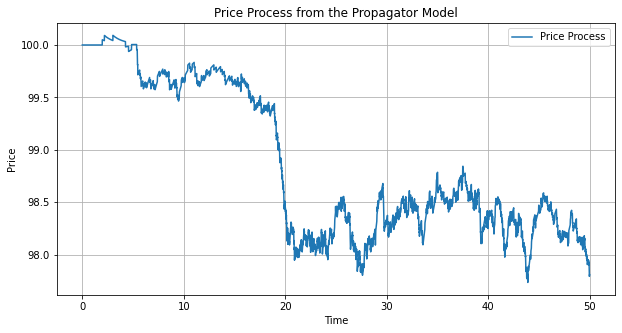

In [4]:
P0 = 100  # Initial price

def compute_price_at_time(t, buy_events, sell_events, P0, zeta):
    buy_impact = np.sum([zeta(t - event) for event in buy_events if event < t])
    sell_impact = np.sum([zeta(t - event) for event in sell_events if event < t])
    return P0 + buy_impact - sell_impact

time_grid = np.linspace(0, T, int(T/0.01))
price_process = np.array([compute_price_at_time(t, buy_events, sell_events, P0, zeta)
                           for t in time_grid])

plt.figure(figsize=(10, 5))
plt.plot(time_grid, price_process, label="Price Process")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price Process from the Propagator Model")
plt.legend()
plt.grid(True)
plt.savefig("propagator_model.png", dpi=300)
plt.show()


## Enforce Martingale Price Dynamics

we want to verify the important hypothesis that the price is martingale in our price process. A process is a martingale if the expected future value, conditioned on current information, equals its current value. For our propagator model, this implies

$$
E[P(t)|F_T] = P_0 \quad \text{for all } t,
$$


To do so
   We simulate $N$ independent realizations of the price process. Each simulation generates its own set of buy and sell events using Ogata's thinning algorithm and computes the corresponding price process.

   By averaging the price processes across the $N$ simulations at each time point, we approximate the expected price process. For a martingale, this average should remain roughly constant and equal to the initial price $P_0$.

Let's now see the implementation.


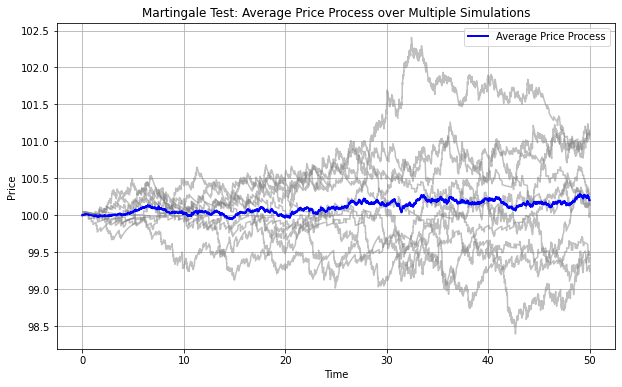

Initial price: 100, Average final price: 100.20


In [5]:
def simulate_price_path(P0, mu, T, dt, phi, zeta):
    """
    Simulate a single price path using the propagator model.
    """
    buy_events = simulate_hawkes_process(mu, T, phi)
    sell_events = simulate_hawkes_process(mu, T, phi)
    time_grid = np.linspace(0, T, int(T/dt))
    price_process = np.array([compute_price_at_time(t, buy_events, sell_events, P0, zeta)
                               for t in time_grid])
    return time_grid, price_process

N = 10  
dt = 0.01
price_paths = []

for _ in range(N):
    t_grid, price_process = simulate_price_path(P0, mu, T, dt, phi, zeta)
    price_paths.append(price_process)

price_paths = np.array(price_paths)
avg_price = np.mean(price_paths, axis=0)

plt.figure(figsize=(10, 6))
for i in range(min(N, 10)):
    plt.plot(t_grid, price_paths[i], color='gray', alpha=0.5)
plt.plot(t_grid, avg_price, label="Average Price Process", color='blue', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Martingale Test: Average Price Process over Multiple Simulations")
plt.legend()
plt.grid(True)
plt.savefig("martingale_property.png", dpi=300)
plt.show()
print(f"Initial price: {P0}, Average final price: {avg_price[-1]:.2f}")


# Step 7: Simulate Metaorders and Their Impact

Here we simulate the effect of a metaorder on the price process. A metaorder is executed with a constant trading rate over a fixed time duration $\tau$. The expected impact of this metaorder is given by:

$$
MI(t) = F \int_0^{t \wedge \tau} \zeta(t-s) \, ds,
$$

where:
- **$F$** is the metaorder flow size (a scaling factor for the impact).
- **$\tau$** is the duration of the metaorder execution.
- **$\zeta(t-s)$** is the propagator function that describes how the impact of an order decays over time.
- **$t \wedge \tau$** denotes the minimum of $t$ and $\tau$, ensuring that we only integrate over the active metaorder period.


We define below a function `metaorder_impact` that computes $MI(t)$ by numerically integrating $\zeta(t-s)$ over the interval $[0, \min(t,\tau)]$.
We then compute the impact over a range of time values and plot the resulting impact curve.
A vertical dashed line at $t = \tau$ marks the end of the metaorder execution.



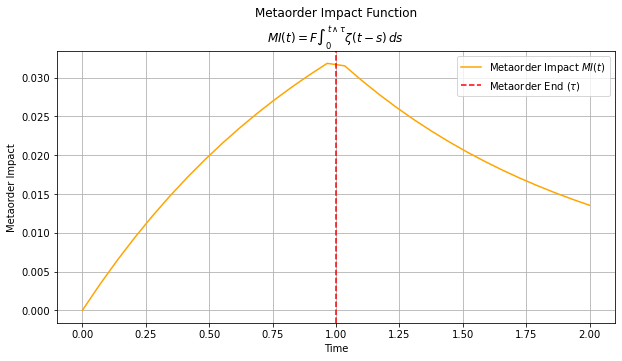

In [6]:
def metaorder_impact(t, tau, F, zeta, integration_steps=1000):
    upper_limit = min(t, tau)
    s_grid = np.linspace(0, upper_limit, integration_steps)
    integrand = zeta(t - s_grid)
    integral_value = np.trapz(integrand, s_grid)
    impact = F * integral_value
    return impact

# Metaorder parameters
F = 1.0     
tau = 1.0   # Metaorder is executed from t=0 to t=tau

time_grid_meta = np.linspace(0, 2, 30)
MI = np.array([metaorder_impact(t, tau, F, zeta) for t in time_grid_meta])

plt.figure(figsize=(10, 5))
plt.plot(time_grid_meta, MI, label="Metaorder Impact $MI(t)$", color='orange')
plt.axvline(x=tau, color='red', linestyle='--', label="Metaorder End ($\\tau$)")
plt.xlabel("Time")
plt.ylabel("Metaorder Impact")
plt.title("Metaorder Impact Function\n$MI(t) = F \\int_0^{t \\wedge \\tau} \\zeta(t-s)\\,ds$")
plt.legend()
plt.grid(True)
plt.savefig("metaorder_impact.png", dpi=300)
plt.show()


# Step 8: Asymptotic Power Law Behavior for Metaorder Impact

We consider a nearly-critical Hawkes process with a heavy-tailed kernel. The tail of the kernel behaves as

$$
\Phi(x) \sim \frac{\alpha\, c^\alpha}{x^{1+\alpha}},
$$

with $\alpha \in (0,0.5)$ and $c$ a scale parameter. This heavy tail implies long memory in the order flow.


To capture the asymptotic behavior, we renormalize the impact:

$$
RMI^T(t) = \frac{1-a_T}{(\tau^T)^{1-\alpha}}\, MI^T(t\,\tau^T),
$$

with $a_T$ being the nearly-critical parameter (e.g. $a_T = 1 - \frac{1}{T}$ for a large $T$). Under appropriate scaling (when $\tau^T \to \infty$ and $\tau^T(1-a_T)^{1/\alpha} \to 0$), the theory predicts

$$
RMI^T(t) \to K' \, t^{1-\alpha}, \quad t \in [0,1],
$$

with the theoretical prefactor

$$
K' = \frac{c^\alpha\, \kappa\, v\, \Phi}{1-\alpha}.
$$


We expect that on a log-log plot the renormalized impact $RMI^T(t)$ will follow a power law with slope $1-\alpha = 0.8$. The code cell below computes $RMI^T(t)$ and compares it with the theoretical curve $K_{\text{theory}}\, t^{1-\alpha}$.


Theoretical K': 0.0013249999999999998


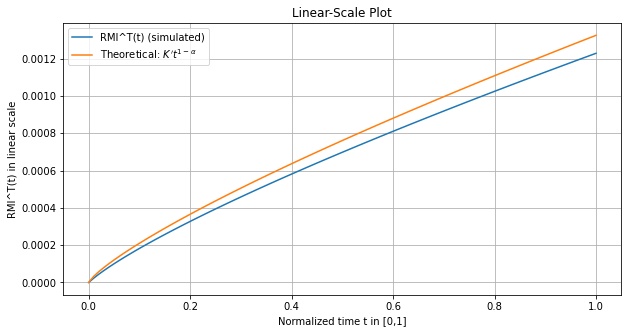

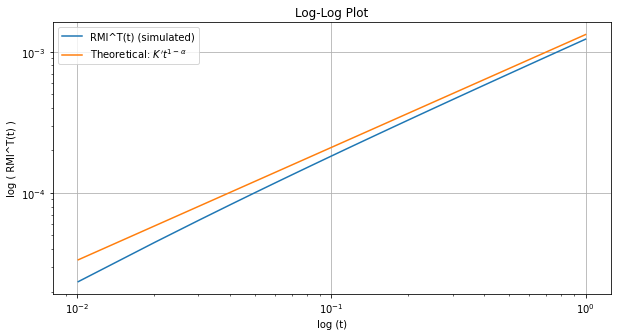

Estimated slope = 0.842
Expected slope = 1 - alpha = 0.80
Theoretical prefactor used = 0.0013


In [7]:

# Parameters
alpha = 0.2
c = 1.0
kappa = 0.00053
v     = 2.0
Phi   = 1.0 

K_theory = (c**alpha) * kappa * v * Phi / (1 - alpha)
print(f"Theoretical K': {K_theory}")

T = 1e4
a_T = 1 - 1/T

tau_T = 100.0
F = 10.0


#we define the heavy tail kernel
def phi_T(s, aT=a_T, alpha=alpha, c=c):
    return aT * (alpha * c**alpha / (s + c)**(1 + alpha))

def zeta_T(s, aT=a_T, alpha=alpha, c=c):
    return 1 - aT*(1 - (c/(s+c))**alpha)

def RMI_T_of_t(t, aT=a_T, tauT=tau_T, F=F):
    s_grid = np.linspace(0, t*tauT, 2000)  
    zeta_values = zeta_T(s_grid, aT)
    integral_val = np.trapz(zeta_values, s_grid)
    return F * (1 - aT)/(tauT**(1 - alpha)) * integral_val


t_grid = np.linspace(0, 1, 100)
RMI_vals = np.array([RMI_T_of_t(u) for u in t_grid])

theory_vals = K_theory * (t_grid**(1 - alpha))

plt.figure(figsize=(10, 5))
plt.plot(t_grid, RMI_vals, linestyle='-', label="RMI^T(t) (simulated)")
plt.plot(t_grid, theory_vals, linestyle='-', label=r"Theoretical: $K' t^{1-\alpha}$")
plt.xlabel("Normalized time t in [0,1]")
plt.ylabel("RMI^T(t) in linear scale")
plt.title("Linear-Scale Plot")
plt.legend()
plt.grid(True)
plt.savefig("powerlaw_impact_simulation.png", dpi=300)
plt.show()


plt.figure(figsize=(10, 5))
mask_nonzero = t_grid > 0
plt.loglog(t_grid[mask_nonzero], RMI_vals[mask_nonzero], linestyle='-', label="RMI^T(t) (simulated)")
plt.loglog(t_grid[mask_nonzero], theory_vals[mask_nonzero], linestyle='-', label=r"Theoretical: $K' t^{1-\alpha}$")
plt.xlabel("log (t)")
plt.ylabel("log ( RMI^T(t) )")
plt.title("Log-Log Plot")
plt.legend()
plt.grid(True)
plt.savefig("powerlaw_impact_simulation_log.png", dpi=300)
plt.show()



log_t = np.log(t_grid[mask_nonzero])
log_rmi = np.log(RMI_vals[mask_nonzero])
coefs = np.polyfit(log_t, log_rmi, 1)
slope_estimate = coefs[0]

print(f"Estimated slope = {slope_estimate:.3f}")
print(f"Expected slope = 1 - alpha = {1 - alpha:.2f}")
print(f"Theoretical prefactor used = {K_theory:.4f}")


# Part 2  - Modeling the Full LOB

In [8]:
#setting up the enviroinement

T = 1000            # Total simulation time (in seconds)
num_queues = 6      # 3 bid queues and 3 ask queues (K = 3 per side)
lambda_const = 0.1  # orders per second
tick_size = 1

### Simulation of a Single Poisson Queue

This simulation models a simple Poisson queue, where new limit orders arrive at a constant rate $\lambda$ without any cancellations or executions.

The inter-arrival times of orders are drawn from an exponential distribution with rate $\lambda$, ensuring that order arrivals follow a Poisson process. The queue size increases monotonically as no orders are removed. This setup serves as a baseline model to understand order flow before introducing more complex dynamics.

The figure below shows the evolution of queue size over time. The staircase pattern illustrates the discrete nature of order arrivals, highlighting the need for additional mechanisms such as cancellations or executions to maintain realistic queue dynamics.


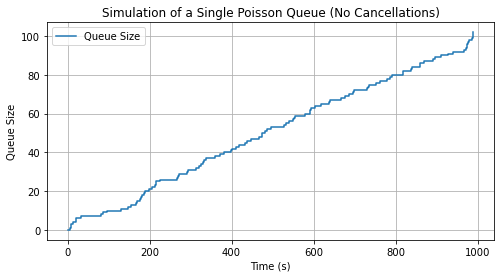

In [9]:

def simulate_poisson_queue(T, lambda_val):
    t = 0
    times = [t]
    queue_sizes = [0]
    
    while t < T:
        dt = np.random.exponential(1 / lambda_val)
        t += dt
        if t > T:
            break
        times.append(t)
        queue_sizes.append(queue_sizes[-1] + 1)
    
    return times, queue_sizes

times, sizes = simulate_poisson_queue(T, lambda_const)

plt.figure(figsize=(8, 4))
plt.step(times, sizes, where='post', label='Queue Size')
plt.xlabel('Time (s)')
plt.ylabel('Queue Size')
plt.title('Simulation of a Single Poisson Queue (No Cancellations)')
plt.legend()
plt.grid(True)
plt.savefig("SinglePoissonQueue.png", dpi=300)
plt.show()


## Extending to Multiple Queues & Event-Driven Simulation


we model the entire limit order book (LOB) as a collection of independent queues. For example, consider a simplified LOB with 6 queues: 3 on the bid side and 3 on the ask side. Each queue follows a Poisson process with a constant arrival rate $ \lambda $.


1. For each queue, generate a waiting time to the next event using the exponential distribution with parameter $ \lambda $.
2. Identify the queue with the smallest waiting time. This is the next event to occur.
3. Advance the simulation time by that minimum waiting time.
4. Increment the order count of the selected queue.
5. Update the waiting time for the selected queue (by generating a new exponential random variable) and decrease the remaining waiting times for the other queues.

- Record the state of the LOB (i.e., the vector of queue sizes) at each event time for later analysis.

This event-driven approach ensures that we correctly simulate which queue "jumps" first in continuous time.

**Note:** For now, we ignore cancellations and only simulate order arrivals.


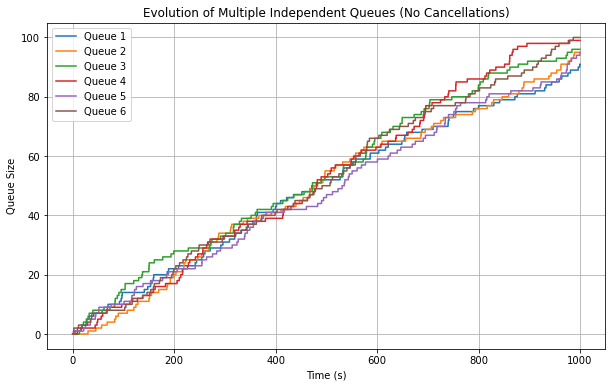

In [10]:
def simulate_lob(T, lambda_val, num_queues):
    """
    Simulate a limit order book (LOB) with multiple independent queues.
    Each queue follows a Poisson process with a constant arrival rate.
    
    Parameters:
        T           : Total simulation time.
        lambda_val  : Constant intensity (arrival rate).
        num_queues  : Number of independent queues.
        
    Returns:
        times  : List of event times.
        states : List of LOB states (queue sizes vector) at each event.
    """
    t = 0
    next_event_times = np.random.exponential(1 / lambda_val, size=num_queues)
    state = np.zeros(num_queues, dtype=int)
    times = [t]
    states = [state.copy()]
    while t < T:
        dt = np.min(next_event_times)
        queue_idx = np.argmin(next_event_times)
        t += dt
        if t > T:
            break
        state[queue_idx] += 1
        times.append(t)
        states.append(state.copy())
        
        next_event_times -= dt
        next_event_times[queue_idx] = np.random.exponential(1 / lambda_val)
    
    return times, states

# Run
times, lob_states = simulate_lob(T, lambda_const, num_queues)
lob_states = np.array(lob_states)
plt.figure(figsize=(10, 6))
for i in range(num_queues):
    plt.step(times, lob_states[:, i], where='post', label=f'Queue {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Queue Size')
plt.title('Evolution of Multiple Independent Queues (No Cancellations)')
plt.legend()
plt.grid(True)
plt.savefig("SingleQueue.png", dpi=300)
plt.show()


## Simulating Multiple Queues with State-Dependent Intensities

In this step, we modify our LOB simulation to use state-dependent intensities. Instead of using a fixed arrival rate $ \lambda $ for each queue, we define an intensity function:

$$
\lambda(q) = \lambda_0 e^{-\alpha q}
\
$$
where:
- $ \lambda_0 $ is the base arrival rate,
- $ \alpha $ controls how strongly the arrival rate decreases with the queue size $ q $.


This approach allows us to see how the queue dynamics are affected by the current level of liquidity.

**Note:** For now, cancellations are still ignored.





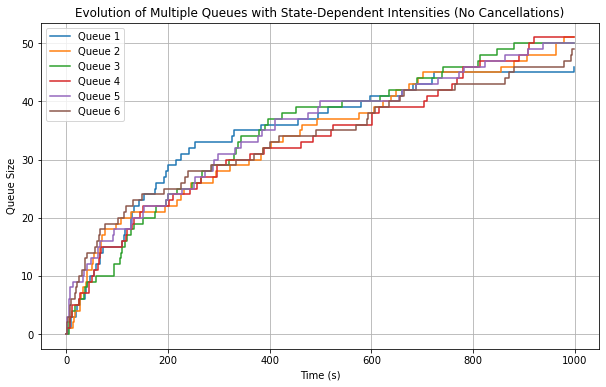

In [11]:
# Simulation parameters
           # Total simulation time (seconds)
lambda0 = 0.2        # Base arrival rate (orders per second)
alpha = 0.05         # Parameter controlling state-dependence


def state_dependent_intensity(q, lambda0, alpha):
    return lambda0 * np.exp(-alpha * q)

def simulate_lob_state_dependent(T, lambda0, alpha, num_queues):
    """
    Simulate a limit order book (LOB) with multiple independent queues that have state-dependent intensities.
    
    Parameters:
        T       : Total simulation time.
        lambda0 : Base arrival rate.
        alpha   : Decay parameter for state-dependence.
        num_queues : Number of queues in the LOB.
        
    Returns:
        times  : List of event times.
        states : List of LOB states (vector of queue sizes) at each event.
    """
    t = 0
    state = np.zeros(num_queues, dtype=int)
    next_event_times = np.array([
        np.random.exponential(1 / state_dependent_intensity(q=state[i], lambda0=lambda0, alpha=alpha))
        for i in range(num_queues)
    ])
    
    times = [t]
    states = [state.copy()]
    
    while t < T:
        dt = np.min(next_event_times)
        queue_idx = np.argmin(next_event_times)
        t += dt
        
        if t > T:
            break
        state[queue_idx] += 1
        times.append(t)
        states.append(state.copy())
        next_event_times -= dt
        next_event_times[queue_idx] = np.random.exponential(
            1 / state_dependent_intensity(q=state[queue_idx], lambda0=lambda0, alpha=alpha)
        )
    
    return times, states

# Run the state-dependent simulation
times_sd, states_sd = simulate_lob_state_dependent(T, lambda0, alpha, num_queues)

states_sd = np.array(states_sd)
plt.figure(figsize=(10, 6))
for i in range(num_queues):
    plt.step(times_sd, states_sd[:, i], where='post', label=f'Queue {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Queue Size')
plt.title('Evolution of Multiple Queues with State-Dependent Intensities (No Cancellations)')
plt.legend()
plt.grid(True)
plt.show()


## Incorporating a Hawkes Process for Self-Exciting Order Arrivals

In this step, we extend our LOB simulation by introducing a Hawkes process to capture the self-exciting nature of order flows. A Hawkes process is a point process where each event temporarily increases the arrival rate of future events.


### **Simulate Buy and Sell Order Arrivals:**
- Use a Hawkes process (via Ogata’s thinning algorithm) to generate arrival times for buy orders and sell orders independently.
- We define a kernel function $ \phi(t) $ (for example, an exponential kernel) and a baseline intensity $ \mu $ for the process.

### **Mapping Orders to the LOB:**
- We assume the LOB has two sides (bid and ask), each divided into several queues (e.g., 3 bid queues and 3 ask queues).
- For this step, we map all buy orders to the best bid queue (e.g., queue 0) and all sell orders to the best ask queue (e.g., queue $ K $, where $ K $ is the number of bid queues).

### **Event-Driven LOB Update:**
1. Merge the two event streams (buy and sell) into a single sorted list.
2. At each event time, update the corresponding side of the LOB by incrementing the queue size.
3. Record the LOB state for analysis and plotting.

This approach allows us to study how the self-exciting nature of order flows influences the dynamics of the LOB.



   Q1  Q2  Q3  Q4  Q5  Q6       time
0   0   0   0   1   0   0  28.015816
1   1   0   0   1   0   0  28.279710
2   2   0   0   1   0   0  31.396501
3   2   0   0   2   0   0  32.493295
4   3   0   0   2   0   0  48.360645


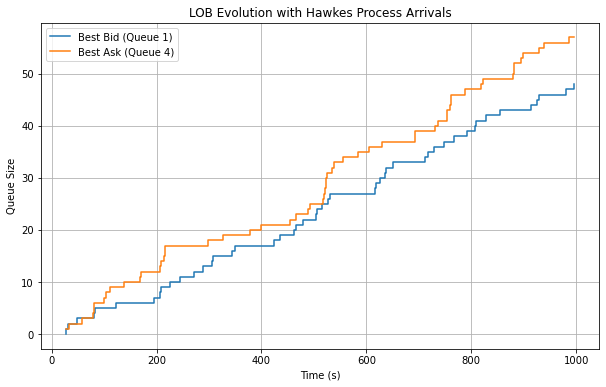

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Simulation parameters     
mu = 0.05    
# Define the kernel phi: exponential decay kernel
phi = lambda t: 0.1 * np.exp(-1.0 * t) * (t > 0)
K = 3
num_queues = 2 * K

buy_events = simulate_hawkes_process(mu, T, phi)
sell_events = simulate_hawkes_process(mu, T, phi)

# For simplicity, we map buy orders to bid queue index 0 and sell orders to ask queue index K.
buy_tagged = [(t, 'buy', 0) for t in buy_events]
sell_tagged = [(t, 'sell', K) for t in sell_events]

all_events = sorted(buy_tagged + sell_tagged, key=lambda x: x[0])
lob_state = np.zeros(num_queues, dtype=int)
event_times = []
lob_states = []
for event in all_events:
    t, order_type, queue_idx = event
    lob_state[queue_idx] += 1
    event_times.append(t)
    lob_states.append(lob_state.copy())
lob_df = pd.DataFrame(lob_states, columns=[f"Q{i+1}" for i in range(num_queues)])
lob_df["time"] = event_times

print(lob_df.head())
plt.figure(figsize=(10, 6))
plt.step(lob_df["time"], lob_df["Q1"], where='post', label='Best Bid (Queue 1)')
plt.step(lob_df["time"], lob_df[f"Q{K+1}"], where='post', label='Best Ask (Queue 4)')
plt.xlabel('Time (s)')
plt.ylabel('Queue Size')
plt.title('LOB Evolution with Hawkes Process Arrivals')
plt.legend()
plt.grid(True)
plt.show()


## Incorporating Reactive Queue Dynamics (Birth–Death Process)

In this step, we extend our LOB simulation to include cancellations (or market orders) alongside arrivals. This creates a **birth–death process** for each queue:

### **Birth (Arrival) Events:**
Orders arrive at a rate $ \lambda_L(q) $ that may depend on the current queue size $ q $. For example, we can use a state-dependent function such as:

$
\lambda_L(q) = \lambda_0 e^{-\alpha q}
$

which decreases as the queue size increases.

### **Death (Cancellation/Execution) Events:**
Orders are removed (via cancellation or execution) at a rate $ \lambda_D(q) $ that typically **increases** with $ q $ (to ensure ergodicity). One simple choice is a linear function:

$
\lambda_D(q) = \delta + \beta q
\$

where:
- $ \delta $ is a baseline removal rate,
- $ \beta $ controls how fast the rate increases.


- For each queue, set the initial state (e.g., zero orders).
- For each queue, generate two waiting times:
  - One for the next **birth event** (using the current birth intensity).
  - One for the next **death event** (using the current death intensity; if the queue is empty, set the death waiting time to infinity).

### **Event-Driven Update:**
1. Across all queues, determine which event (**birth or death**) occurs first by taking the minimum waiting time.
2. Advance the simulation clock by that amount.
3. Update the corresponding queue:
   - Increment for a **birth event**.
   - Decrement for a **death event** (ensuring the queue remains nonnegative).
4. For the affected queue, generate new waiting times for both **birth** and **death** events based on its updated state.
5. For the other queues, subtract the elapsed time from their existing waiting times.




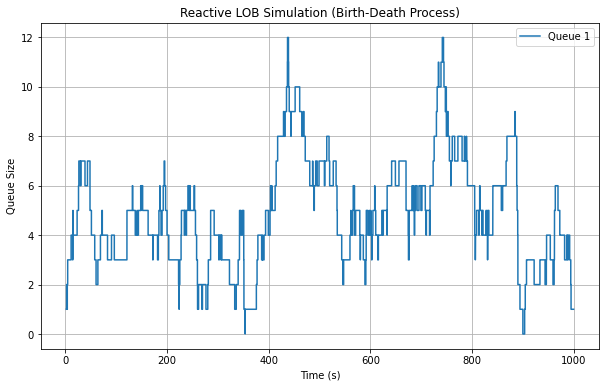

In [16]:
import numpy as np
import matplotlib.pyplot as plt
num_queues = 6
lambda0 = 0.2
alpha = 0.05
delta = 0.05
beta = 0.02

def birth_rate(q, lambda0, alpha):
    return lambda0 * np.exp(-alpha * q)

def death_rate(q, delta, beta):
    return (delta + beta * q) if q > 0 else 0

def simulate_reactive_lob(T, num_queues, lambda0, alpha, delta, beta):
    t = 0
    state = np.zeros(num_queues, dtype=int)
    birth_waits = np.array([
        np.random.exponential(1 / birth_rate(state[i], lambda0, alpha))
        for i in range(num_queues)
    ])
    death_waits = np.array([
        np.inf if state[i] == 0 else np.random.exponential(1 / death_rate(state[i], delta, beta))
        for i in range(num_queues)
    ])

    event_times = []
    event_states = []

    while t < T:
        combined_waits = np.stack((birth_waits, death_waits), axis=1)
        next_event = np.min(combined_waits, axis=1)
        event_type = np.argmin(combined_waits, axis=1)  # 0 = birth, 1 = death

        dt = np.min(next_event)
        queue_idx = np.argmin(next_event)
        if t + dt > T:
            break
        t += dt
        birth_waits -= dt
        death_waits -= dt

        if event_type[queue_idx] == 0:
            # Birth
            state[queue_idx] += 1
        else:
            # Death
            state[queue_idx] = max(state[queue_idx] - 1, 0)

        event_times.append(t)
        event_states.append(state.copy())

        birth_waits[queue_idx] = np.random.exponential(
            1 / birth_rate(state[queue_idx], lambda0, alpha)
        )
        death_rate_val = death_rate(state[queue_idx], delta, beta)
        death_waits[queue_idx] = np.random.exponential(1 / death_rate_val) if death_rate_val > 0 else np.inf

    return np.array(event_times), np.array(event_states)

# Run the reactive LOB 
times_reactive, states_reactive = simulate_reactive_lob(T, num_queues, lambda0, alpha, delta, beta)
states_reactive = np.array(states_reactive)

plt.figure(figsize=(10, 6))
for i in range(1):
    plt.step(times_reactive, states_reactive[:, i], where='post', label=f'Queue {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Queue Size')
plt.title('Reactive LOB Simulation (Birth-Death Process)')
plt.legend()
plt.grid(True)
plt.savefig("SingleQueueBD.png", dpi=300)
plt.show()


## Analysis and Comparison with Theoretical Invariant Distribution

In this step, we analyze the simulation data from our **reactive LOB model (birth–death process)** and compare the **empirical distribution** of a queue’s size with its **theoretical invariant distribution**.

- From our simulation, we select one queue (for example, the first bid queue) and record its size over time.
- We compute a histogram representing the empirical probability distribution of queue sizes.

### **Compute Theoretical Invariant Distribution:**
Based on our birth–death process, the **theoretical invariant distribution** is given by:

$
\pi(n) = \pi(0) \prod_{j=1}^{n} \frac{\lambda_0 e^{-\alpha (j-1)}}{\delta + \beta j}
\$

where:
- $ \pi(0) $ is determined by normalization (i.e., the sum over all $ n $ is 1).

### **Comparison:**
We plot both the empirical histogram and the theoretical distribution for visual comparison.



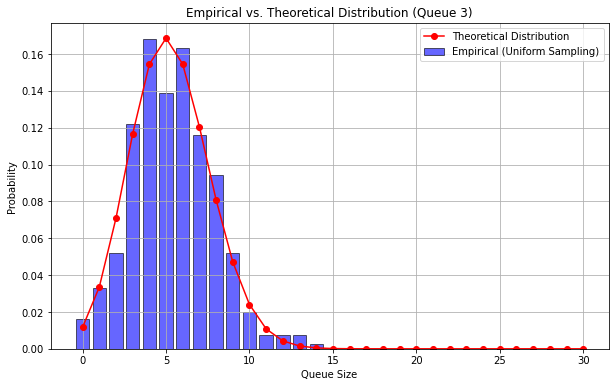

=== Comparison of Mean and Variance ===
Empirical Mean   = 5.3848, Empirical Variance   = 6.0343
Theoretical Mean = 5.2666, Theoretical Variance = 5.4916


In [24]:
# Use a longer simulation time
T_total = 2000.0

event_times, event_states = simulate_reactive_lob(T_total, num_queues, lambda0, alpha, delta, beta)


def sample_uniformly_in_time(event_times, event_states, T_total, dt=1.0):
    """
    Given event-based times and states, sample the queue sizes at uniform time intervals.
    
    event_times: 1D array of times when the state changed
    event_states: 2D array of shape (num_events, num_queues)
    T_total: end of simulation
    dt: sampling interval
    Returns:
      uniform_times: array of sample times
      uniform_states: 2D array of queue states at those times
    """
    uniform_times = np.arange(0, T_total + dt, dt)
    uniform_states = []
    idx = 0
    current_state = np.zeros(event_states.shape[1], dtype=int)
    
    for t in uniform_times:

        while idx < len(event_times) and event_times[idx] <= t:
            current_state = event_states[idx]
            idx += 1
        # Now current_state is the state at time t
        uniform_states.append(current_state.copy())
    
    return uniform_times, np.array(uniform_states)


dt_sample = 1.0
uniform_times, uniform_states = sample_uniformly_in_time(event_times, event_states, T_total, dt_sample)


burn_in_fraction = 0.2  # discard first 20% of the uniform samples
burn_in_index = int(len(uniform_times) * burn_in_fraction)

uniform_times_burned = uniform_times[burn_in_index:]
uniform_states_burned = uniform_states[burn_in_index:]


queue_index = 2  # pick a queue for demonstration
queue_sizes = uniform_states_burned[:, queue_index]
unique_sizes, counts = np.unique(queue_sizes, return_counts=True)
empirical_prob = counts / counts.sum()


emp_mean = queue_sizes.mean()
emp_var = queue_sizes.var()


def theoretical_distribution(lambda0, alpha, delta, beta, n_max=50):
    unnormalized = []
    for n in range(n_max + 1):
        if n == 0:
            unnormalized.append(1.0)
        else:
            ratio = (lambda0 * np.exp(-alpha*(n-1))) / (delta + beta*n)
            unnormalized.append(unnormalized[-1] * ratio)
    total_mass = sum(unnormalized)
    pi_vals = [x / total_mass for x in unnormalized]
    return np.array(pi_vals)

n_max = max(unique_sizes.max(), 20) + 10  # go beyond observed max
pi_vals = theoretical_distribution(lambda0, alpha, delta, beta, n_max=n_max)

theo_mean = np.sum([n * pi_vals[n] for n in range(len(pi_vals))])
theo_var = np.sum([(n - theo_mean)**2 * pi_vals[n] for n in range(len(pi_vals))])



plt.figure(figsize=(10, 6))

plt.bar(unique_sizes, empirical_prob, width=0.8, alpha=0.6,
        label='Empirical (Uniform Sampling)', color='blue', edgecolor='black')

# Theoretical
plt.plot(range(len(pi_vals)), pi_vals, marker='o', linestyle='-',
         color='red', label='Theoretical Distribution')

plt.xlabel('Queue Size')
plt.ylabel('Probability')
plt.title(f'Empirical vs. Theoretical Distribution (Queue {queue_index+1})')
plt.legend()
plt.grid(True)
plt.savefig("comparaisondis.png", dpi=300)
plt.show()

print("=== Comparison of Mean and Variance ===")
print(f"Empirical Mean   = {emp_mean:.4f}, Empirical Variance   = {emp_var:.4f}")
print(f"Theoretical Mean = {theo_mean:.4f}, Theoretical Variance = {theo_var:.4f}")


## Limit Order Book Simulation with **Hawkes-Driven** Arrivals and **Reactive Deaths**

More further, we model the **best bid** and **best ask** queues of a limit order book (LOB), incorporating two key mechanisms:

1. **Hawkes-driven order arrivals**:  
   - Buy and sell orders arrive according to **self-exciting Hawkes processes**, meaning that past events influence future arrivals.  
   - Each side of the order book has its own **baseline intensity** ($\mu_{\text{buy}}$, $\mu_{\text{sell}}$) and an **excitation kernel** ($\phi_{\text{buy}}$, $\phi_{\text{sell}}$) that controls how much past arrivals increase the likelihood of future orders.

2. **State-dependent cancellations/executions** (Reactive Deaths):  
   - Orders leave the queue due to **cancellations or executions**.  
   - The **death rate** for each queue depends on its size:  
     $$ \lambda_D(q) = \delta + \beta q, $$
     where $\delta$ is a baseline removal rate, and $\beta$ controls how much the removal rate increases with queue size.

### **Simulation Dynamics**
- Orders arrive at the best bid or best ask queue based on **Hawkes-driven processes**.
- Each order arrival increases the queue size.
- **Cancellations or executions** remove orders at a rate that depends on the current queue size.
- The system updates event-by-event, ensuring realistic **market microstructure dynamics**.

### **Key Observations**
- **Order clustering**: The **Hawkes process** generates bursts of order activity, reflecting empirical market behavior.
- **Queue-dependent cancellations**: Heavily populated queues experience more frequent order removals.
- **Realistic queue evolution**: Unlike pure Poisson models, this simulation **prevents unbounded queue growth**, maintaining stable queue sizes over time.

The figure below shows the evolution of **best bid** and **best ask** queues over time.  

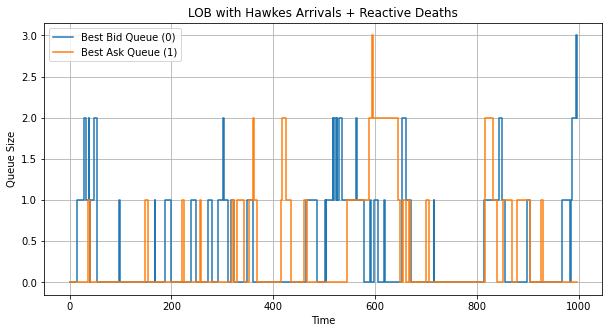

In [31]:

def simulate_lob_hawkes_reactive(
    T, 
    mu_buy, mu_sell,         # Baseline intensities for Hawkes (buy & sell)
    phi_buy, phi_sell,       # Kernel functions for buy & sell
    delta, beta,             # Death rate parameters
    q_init=None
):

    buy_times = simulate_hawkes_process(mu_buy, T, phi_buy)
    sell_times = simulate_hawkes_process(mu_sell, T, phi_sell)
    buy_events = [(t, 0, 'arrival') for t in buy_times]
    sell_events = [(t, 1, 'arrival') for t in sell_times]
    arrival_events = sorted(buy_events + sell_events, key=lambda x: x[0])

    if q_init is None:
        q_init = [0, 0]
    state = np.array(q_init, dtype=int) 
    t = 0.0
    idx_arrival = 0
    death_times = [np.inf, np.inf]
    def resample_death_time(queue_idx, current_time):
        if state[queue_idx] == 0:
            return np.inf
        rate = death_rate(state[queue_idx], delta, beta)
        return current_time + np.random.exponential(1.0 / rate)

    for i in range(2):
        death_times[i] = resample_death_time(i, t)

    times = [t]
    states = [state.copy()]
    while True:
        if idx_arrival < len(arrival_events):
            arrival_time, arrival_queue, arrival_type = arrival_events[idx_arrival]
        else:
            arrival_time = np.inf  # no more arrivals

        # Next death times
        d0, d1 = death_times
        next_event_time = min(arrival_time, d0, d1)
        if next_event_time == np.inf or next_event_time > T:
            break 

        # Advance time
        dt = next_event_time - t
        t = next_event_time
        if t == arrival_time:
            state[arrival_queue] += 1
            idx_arrival += 1
            death_times[arrival_queue] = resample_death_time(arrival_queue, t)

        else:
            if t == d0:
                queue_idx = 0
            else:
                queue_idx = 1
            state[queue_idx] = max(state[queue_idx] - 1, 0)
            death_times[queue_idx] = resample_death_time(queue_idx, t)
        times.append(t)
        states.append(state.copy())

    return np.array(times), np.array(states)


if __name__ == "__main__":
    T_sim = 1000.0
    mu_buy = 0.03
    def phi_buy(t):
        return 0.1 * np.exp(-0.5 * t) if t > 0 else 0

    # Hawkes parameters for sells
    mu_sell = 0.02
    def phi_sell(t):
        return 0.08 * np.exp(-0.5 * t) if t > 0 else 0

    # Death rate parameters
    delta = 0.05
    beta = 0.02

    # Run the combined simulation
    times, states = simulate_lob_hawkes_reactive(
        T=T_sim,
        mu_buy=mu_buy, mu_sell=mu_sell,
        phi_buy=phi_buy, phi_sell=phi_sell,
        delta=delta, beta=beta
    )

    plt.figure(figsize=(10, 5))
    plt.step(times, states[:, 0], where='post', label='Best Bid Queue (0)')
    plt.step(times, states[:, 1], where='post', label='Best Ask Queue (1)')
    plt.xlabel("Time")
    plt.ylabel("Queue Size")
    plt.title("LOB with Hawkes Arrivals + Reactive Deaths")
    plt.legend()
    plt.grid(True)
    plt.savefig("lobbd.png", dpi=300)
    plt.show()


## Price Dynamics Driven by **Order Flow Impact**

This simulation models the **price evolution** of an asset based on **Hawkes-driven order arrivals** and a **decaying impact function**. Unlike traditional models where price changes are exogenous, this approach ties price movement directly to the **order flow**, a key feature of market microstructure modeling.

### **Price Impact Model**
The price at time $t$ is given by:
$$\
P(t) = P_0 + \sum_{\text{buys}} \zeta(t - t_b) - \sum_{\text{sells}} \zeta(t - t_s)
\$$
where:
- $P_0$ is the initial price,
- $\zeta(t)$ is the **impact function**, determining how each order affects the price,
- Buy orders **increase** the price, while sell orders **decrease** it.

### **Impact Function**
To capture the **temporary nature of order impact**, we use an **exponentially decaying** function:
$$\
\zeta(t) = \zeta_0 e^{-\gamma t}
\$$
where:
- $\zeta_0$ is the initial impact of an order,
- $\gamma$ is the decay rate, controlling how quickly an order's impact fades over time.

### **Market Microstructure Effects**
- **Hawkes-driven arrivals** generate bursts of buying and selling activity, leading to **short-term price shocks**.
- The **exponential decay** ensures that past orders have **diminishing influence** on future prices.
- This approach **endogenizes price formation**, showing how **liquidity fluctuations** influence short-term market movements.

The figure below illustrates the **price path** over time, shaped by Hawkes-driven order arrivals.  
This model bridges **queue dynamics** and **price impact**, providing a **realistic framework** for understanding how order flow translates into price changes in financial markets.


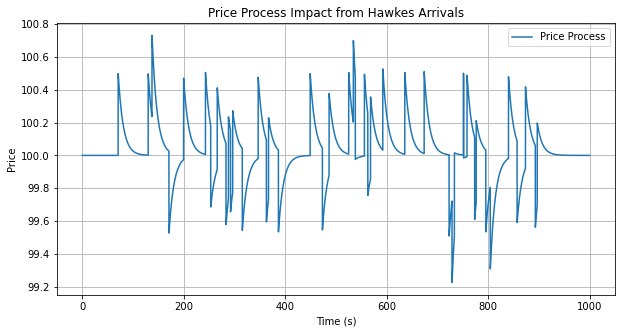

In [34]:
P0 = 100.0       
zeta0 = 0.5      
decay = 0.1      

def zeta(t):
    return zeta0 * np.exp(-decay * t) if t >= 0 else 0

def compute_price_at_time(t, buy_events, sell_events, P0, zeta):
    buy_impact = np.sum([zeta(t - tb) for tb in buy_events if tb < t])
    sell_impact = np.sum([zeta(t - ts) for ts in sell_events if ts < t])
    return P0 + buy_impact - sell_impact

T_sim = 1000.0 
def phi_buy(t):
    return 0.1 * np.exp(-0.5 * t) if t > 0 else 0

mu_sell = 0.02
def phi_sell(t):
    return 0.08 * np.exp(-0.5 * t) if t > 0 else 0

buy_events = simulate_hawkes_process(mu_buy, T_sim, phi_buy)
sell_events = simulate_hawkes_process(mu_sell, T_sim, phi_sell)

# Here we consider all buy arrivals as affecting the best bid (queue 0)
# and all sell arrivals as affecting the best ask (queue 1)


time_grid = np.linspace(0, T_sim, int(T_sim / 0.1))
price_process = np.array([compute_price_at_time(t, buy_events, sell_events, P0, zeta)
                           for t in time_grid])


plt.figure(figsize=(10, 5))
plt.plot(time_grid, price_process, label="Price Process")
plt.xlabel("Time (s)")
plt.ylabel("Price")
plt.title("Price Process Impact from Hawkes Arrivals")
plt.legend()
plt.grid(True)
plt.savefig("price_lob.png", dpi=300)
plt.show()
